<a href="https://colab.research.google.com/github/kanri3/deep_learning_day1_day2/blob/main/2_4_2_double_comvolution_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

In [ ]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# Affine

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応        
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        # print("self.x.shape:", self.x.shape)
        # print("self.W.shape:", self.W.shape)
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx


# double_comvolution_network

In [ ]:
class DoubleConvNet:
    # conv - relu - pool - conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28),
            conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
            conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
            hidden_size=100, output_size=10, weight_init_std=0.01):

        conv_output_size_1 = (input_dim[1] - conv_param_1['filter_size'] + 2 * conv_param_1['pad']) / conv_param_1['stride'] + 1
        conv_output_size_2 = (conv_output_size_1 / 2 - conv_param_2['filter_size'] + 2 * conv_param_2['pad']) / conv_param_2['stride'] + 1        
        pool_output_size = int(conv_param_2['filter_num'] * (conv_output_size_2 / 2) * (conv_output_size_2 / 2))        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size'])
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = weight_init_std * np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size'])
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])
        self.params['W3'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] = layers.Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Pool2'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W4'], self.params['b4'])
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i * batch_size : (i + 1) * batch_size]
            td = d[i * batch_size : (i + 1) * batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis = 1)
            acc += np.sum(y == td)
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db        
        grad['W3'], grad['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W4'], grad['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grad

# pooling層を一つ減らす
DoubleConvNetをアレンジ  
前：conv - relu - pool - conv - relu - pool - affine - relu - affine - softmax

後：conv - relu - conv - relu - pool - affine - relu - affine - softmax

In [ ]:
class DoubleConvNetArr:
    def __init__(self, input_dim=(1, 28, 28),
            conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
            conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
            hidden_size=100, output_size=10, weight_init_std=0.01):

        conv_output_size_1 = (input_dim[1] - conv_param_1['filter_size'] + 2 * conv_param_1['pad']) / conv_param_1['stride'] + 1
        conv_output_size_2 = (conv_output_size_1 / 2 - conv_param_2['filter_size'] + 2 * conv_param_2['pad']) / conv_param_2['stride'] + 1

        pool_output_size_arr = int(conv_param_2['filter_num'] * conv_output_size_2 ** 2)        
        # pool_output_size = int(conv_param_2['filter_num'] * (conv_output_size_2 / 2) * (conv_output_size_2 / 2))        

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size'])
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = weight_init_std * np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size'])
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])

        self.params['W3'] = weight_init_std * np.random.randn(pool_output_size_arr, hidden_size)
        # self.params['W3'] = weight_init_std * np.random.randn(pool_output_size * 4, hidden_size)
        # self.params['W3'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])
        self.layers['Relu1'] = layers.Relu()

        # self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        
        self.layers['Conv2'] = layers.Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Pool2'] = layers.Pooling(pool_h = 2, pool_w = 2, stride = 2)
        self.layers['Affine1'] = Affine(self.params['W3'], self.params['b3'])
        # self.layers['Affine1'] = layers.Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = layers.Relu()
        self.layers['Affine2'] = Affine(self.params['W4'], self.params['b4'])
        # self.layers['Affine2'] = layers.Affine(self.params['W4'], self.params['b4'])
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=10):
    # def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db        
        grad['W3'], grad['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W4'], grad['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grad

# Adam

In [ ]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grad):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.learning_rate * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grad[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grad[key] ** 2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

# 比べちゃうのかよ！

In [ ]:
def compare(network, graph_title):
    train_loss_list = []
    accuracies_train = []
    accuracies_test = []
    plot_interval=10

    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        d_batch = d_train[batch_mask]
        
        grad = network.gradient(x_batch, d_batch)
        Adam().update(network.params, grad)
        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)

        if (i + 1) % plot_interval == 0 or i == 0:
            accr_train = network.accuracy(x_train, d_train)
            accr_test = network.accuracy(x_test, d_test)
            accuracies_train.append(accr_train)
            accuracies_test.append(accr_test)
            
            print('Generation: ' + str(i + 1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i + 1) + '. 正答率(テスト) = ' + str(accr_test))               

    lists = range(0, iters_num + 1, plot_interval)
    plt.plot(lists, accuracies_train, label = "training set")
    plt.plot(lists, accuracies_test,  label = "test set")
    plt.legend(loc = "lower right")
    plt.title(graph_title)
    plt.xlabel("count")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    # グラフの表示
    plt.show()

データ読み込み完了
Generation: 1. 正答率(トレーニング) = 0.1182
                : 1. 正答率(テスト) = 0.132
Generation: 10. 正答率(トレーニング) = 0.1126
                : 10. 正答率(テスト) = 0.126
Generation: 20. 正答率(トレーニング) = 0.1538
                : 20. 正答率(テスト) = 0.17
Generation: 30. 正答率(トレーニング) = 0.216
                : 30. 正答率(テスト) = 0.224
Generation: 40. 正答率(トレーニング) = 0.3582
                : 40. 正答率(テスト) = 0.368
Generation: 50. 正答率(トレーニング) = 0.3914
                : 50. 正答率(テスト) = 0.369
Generation: 60. 正答率(トレーニング) = 0.491
                : 60. 正答率(テスト) = 0.493
Generation: 70. 正答率(トレーニング) = 0.5696
                : 70. 正答率(テスト) = 0.539
Generation: 80. 正答率(トレーニング) = 0.5062
                : 80. 正答率(テスト) = 0.475
Generation: 90. 正答率(トレーニング) = 0.5422
                : 90. 正答率(テスト) = 0.508
Generation: 100. 正答率(トレーニング) = 0.656
                : 100. 正答率(テスト) = 0.644


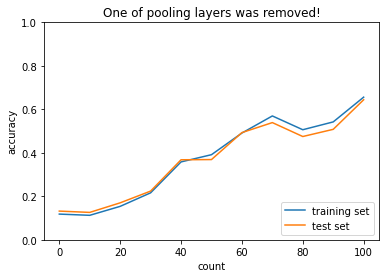

Generation: 1. 正答率(トレーニング) = 0.1126
                : 1. 正答率(テスト) = 0.126
Generation: 10. 正答率(トレーニング) = 0.099
                : 10. 正答率(テスト) = 0.094
Generation: 20. 正答率(トレーニング) = 0.2006
                : 20. 正答率(テスト) = 0.22
Generation: 30. 正答率(トレーニング) = 0.107
                : 30. 正答率(テスト) = 0.11
Generation: 40. 正答率(トレーニング) = 0.2444
                : 40. 正答率(テスト) = 0.265
Generation: 50. 正答率(トレーニング) = 0.1858
                : 50. 正答率(テスト) = 0.193
Generation: 60. 正答率(トレーニング) = 0.2858
                : 60. 正答率(テスト) = 0.294
Generation: 70. 正答率(トレーニング) = 0.3156
                : 70. 正答率(テスト) = 0.351
Generation: 80. 正答率(トレーニング) = 0.3494
                : 80. 正答率(テスト) = 0.334
Generation: 90. 正答率(トレーニング) = 0.3176
                : 90. 正答率(テスト) = 0.337
Generation: 100. 正答率(トレーニング) = 0.4492
                : 100. 正答率(テスト) = 0.464


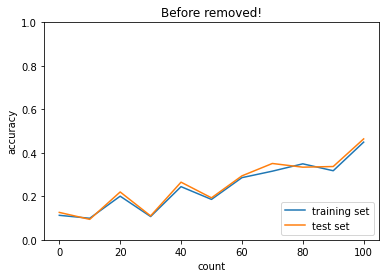

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)
print("データ読み込み完了")
# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]
# optimizer = optimizer.Adam()
# 時間がかかるため100に設定
iters_num = 100
# iters_num = 1000
train_size = x_train.shape[0]
batch_size = 10
# batch_size = 100
network = DoubleConvNetArr(input_dim = (1, 28, 28), hidden_size = 100, output_size = 10, weight_init_std = 0.01,
                          conv_param_1 = {'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                          conv_param_2 = {'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1})
compare(network, "One of pooling layers was removed!")

network = DoubleConvNet(input_dim = (1, 28, 28), hidden_size = 100, output_size = 10, weight_init_std = 0.01,
                          conv_param_1 = {'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                          conv_param_2 = {'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1})
compare(network, "Before removed!")
